In [28]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [29]:
fileprefix = "full" # pilot_[1,2,4]
datafolder = '../results/'
filepath = '{}/{}_results.json'.format(datafolder,fileprefix)


In [30]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../results/full_results.json'

In [ ]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        # Update condition here by setting part_object["condition"]
        # print(part_object["condition"])
        # part_object["condition"] = 1
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

In [31]:
part_data.keys()


dict_keys(['612cb8236aa1cef2599e6f59', '61375098ac2bf903b0364ec3', '64803fe717b0a137be421ae1', '5db050bee16e28001752bc92', '60f724fd8ec131e82a00b129', '6139d8c791c9b4805690b33e', '5b52fb6cb3c9400001f23bb5', '612537b2bd6b4a38f4e7f63a', '5dc3ebd9d0b86f2c8dc18c30', '5b2c0994f1ca3c000190196a', '615ad127d286180356188f84', '6156e9372fa5f9c6cc31eb63', '5fc0c7b73605db59cfd30666', '61702a081098614cd58391a8', '613758e7a80409ba7f5affb6', '60fb1b68ff87fb94e0e721f6', '6152c05b866a2622004014a5', '605996d037bce4fb5488a375', '5e9027110aacc7320bd9a84b', '61649f39b3155900189833cb', '61644a9055a7fdced6a7aa9c', '60ed6ef739959cc28d143526', '5f04de147fee46163c1b40e1', '60b0f62eb8e276ae78fd6180', '64699c39810132db3b4250b1', '615a2c11b1a80d0b33a58bf9', '6153703d974b2bf60bccf6e2', '60eb29c01cbb5ca4a8a5ea2e', '60be90f1912d5331e734e92c', '5f1c5d097881234e5034cb12', '615b5ddab1de3c02771daed5', '611d317b41f033a2bc24ca51', '614769c080877000c8de42ee', '611d0d396f50f8e800c6b740', '60f814d5348f2f80c0e60c3a', '603efeba

In [32]:
len(part_data.keys())

281

# Reading Data from Already Created Participant Data Files

In [228]:
fileprefix = "full" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [229]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [230]:
len(part_data.keys())

281

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [231]:
# List of participants who are excluded and the reason for exclusion

excluded_parts = []

In [232]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = int(trial['trialdata']['response']['effort'])
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

612cb8236aa1cef2599e6f59
612cb8236aa1cef2599e6f59 mdp
61375098ac2bf903b0364ec3
61375098ac2bf903b0364ec3 beginning
64803fe717b0a137be421ae1
5db050bee16e28001752bc92
60f724fd8ec131e82a00b129
6139d8c791c9b4805690b33e
5b52fb6cb3c9400001f23bb5
612537b2bd6b4a38f4e7f63a
5dc3ebd9d0b86f2c8dc18c30
5b2c0994f1ca3c000190196a
615ad127d286180356188f84
615ad127d286180356188f84 beginning
6156e9372fa5f9c6cc31eb63
5fc0c7b73605db59cfd30666
61702a081098614cd58391a8
613758e7a80409ba7f5affb6
60fb1b68ff87fb94e0e721f6
6152c05b866a2622004014a5
605996d037bce4fb5488a375
5e9027110aacc7320bd9a84b
61649f39b3155900189833cb
61644a9055a7fdced6a7aa9c
60ed6ef739959cc28d143526
5f04de147fee46163c1b40e1
60b0f62eb8e276ae78fd6180
60b0f62eb8e276ae78fd6180 mdp
64699c39810132db3b4250b1
64699c39810132db3b4250b1 mdp
615a2c11b1a80d0b33a58bf9
6153703d974b2bf60bccf6e2
60eb29c01cbb5ca4a8a5ea2e
60be90f1912d5331e734e92c
60be90f1912d5331e734e92c mdp
5f1c5d097881234e5034cb12
615b5ddab1de3c02771daed5
611d317b41f033a2bc24ca51
614769c0808770

In [233]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

275


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,3005.539,3005.539,1,2.0,0,670.227,0.00,0,mdp,False,6,-1,False
1,61375098ac2bf903b0364ec3,2023-08-04 09:44:50.707300,68.022,68.022,0,0.0,0,0.000,0.00,0,beginning,False,6,-1,False
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,1676.000,1657.000,0,3.0,40,1199.156,95.60,0,None,True,3,0,True
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,1460.000,1446.883,0,1.0,40,1006.268,-198.60,0,None,True,3,0,True
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2231.000,2166.000,0,1.0,40,1736.868,-387.40,0,None,True,3,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2091.000,2081.000,1,3.0,40,1604.206,1155.80,0,None,True,3,0,True
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2505.000,2472.000,1,2.0,40,1940.350,799.05,0,None,True,3,0,True
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2154.000,2131.000,1,1.0,40,1391.441,-212.50,0,None,True,3,0,True
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,1766.000,1752.000,0,1.0,40,1361.610,1109.80,0,None,True,3,0,True


In [234]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

10


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
1,61375098ac2bf903b0364ec3,2023-08-04 09:44:50.707300,NaT,2023-08-04 09:45:12.705083,6,chrome,linux,en-ZA,68.022,68.022,...,,{},0,None,True,0.0,0.0,-68.022,NaN,NaN
10,615ad127d286180356188f84,2023-08-03 13:54:13.993456,NaT,2023-08-03 13:54:38.050669,6,chrome,windows,en-GB,98.598,98.598,...,,{},0,None,True,0.0,0.0,-98.598,NaN,NaN
44,6112d782efc9ce932196cc7e,2023-08-04 14:25:59.589083,NaT,2023-08-04 14:26:12.160797,6,chrome,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
63,603ea08e7dc2aaf9eb6d9225,2023-08-04 09:36:01.865797,NaT,2023-08-04 09:36:12.315501,6,chrome,windows,en-US,10.435,10.435,...,,{},0,None,True,0.0,0.0,-10.435,NaN,NaN
91,611441187aa655b0bd7a7c69,2023-08-04 09:37:21.475766,NaT,2023-08-04 09:37:32.312466,2,chrome,windows,en-US,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
119,60d65e8c766ade1e2fcd362b,2023-08-03 13:55:20.116841,NaT,2023-08-03 13:55:35.315398,6,chrome,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
132,60d1bf1c234f11f55bfcd276,2023-08-04 09:41:26.295270,NaT,2023-08-04 09:41:41.195316,2,chrome,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
217,607c1d635d5767489a9623eb,2023-08-08 09:13:07.447577,NaT,2023-08-08 09:13:46.988014,6,chrome,linux,en-US,87.234,87.234,...,,{},0,None,True,0.0,0.0,-87.234,NaN,NaN
244,6128da24dd2b6292c122edb3,2023-08-04 14:30:17.679561,NaT,2023-08-04 14:30:31.944449,6,chrome,windows,en-US,20.561,20.561,...,,{},0,None,True,0.0,0.0,-20.561,NaN,NaN
259,60d096244aeaf354bdff6c0f,2023-08-04 14:29:49.846685,NaT,2023-08-04 14:30:28.807780,2,chrome,linux,en-US,27.031,27.031,...,,{},0,None,True,0.0,0.0,-27.031,NaN,NaN


In [235]:
for p in immediate_drops.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [236]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

265


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,NaT,2023-08-04 09:43:17.221980,6,chrome,windows,en-US,3005.539,3005.539,...,,{},0,None,True,0.00,670.227,-2335.312,NaN,NaN
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.000,1657.000,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.000,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.000,2166.000,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.000,2286.000,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.000,2081.000,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.000,2472.000,...,"it wasnt difficult, i just adopted the new str...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2023-08-04 15:10:25.110262,2023-08-04 14:34:53.755028,3,chrome,windows,en-GB,2154.000,2131.000,...,quite difficult,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",False,-212.50,1391.441,-739.559,27629.050,0.0
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.000,1752.000,...,not very difficult. Time and the ability to re...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0


In [237]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [238]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

3
60fe162c674236016c66145f, 0.66 1
6455c9898efbcab4a705968b, 0.54 0
611cbdbbd719071f5e227164, 0.47 0


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_70805/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
162,60fe162c674236016c66145f,2023-08-08 08:59:05.802026,NaT,2023-08-08 08:59:19.296760,6,safari,macos,en-GB,395.683,395.683,...,{},0,None,True,0.0,0.0,-395.683,NaN,NaN,0.659472
243,6455c9898efbcab4a705968b,2023-08-04 09:43:04.593064,NaT,2023-08-04 09:43:22.100225,6,chrome,windows,en-US,326.766,326.766,...,{},0,None,True,0.0,0.0,-326.766,NaN,NaN,0.544610
263,611cbdbbd719071f5e227164,2023-08-04 09:39:06.442303,NaT,2023-08-04 09:39:22.472963,6,chrome,windows,en-US,283.520,283.520,...,{},0,None,True,0.0,0.0,-283.520,NaN,NaN,0.472533


In [239]:
for p in early_quitters.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [240]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

30
612cb8236aa1cef2599e6f59, 1.12
60b0f62eb8e276ae78fd6180, 0.75
64699c39810132db3b4250b1, 0.68
60be90f1912d5331e734e92c, 0.31
611d0d396f50f8e800c6b740, 1.54
615b37de9f81596034aeb896, 0.30
610d4b020c0ec927cbd29bb4, 3.22
6152f8ecefde7f8298316ee6, 0.18
60f99eebe697a698c80fcb03, 0.91
61502b0caeeb72158debb130, 0.57
60b730d71e6cc3224b7ad99e, 0.74
614fb1dd07393b9789143d2b, 1.34
60f5a5d3453af9cc8bf9d7d2, 0.26
6128b55755dd29503d0d3e7a, 1.59
649e9418513d333d2da7e637, 0.77
6159e587cc01e08668d4d7bd, 0.39
646a0c2edcaaf0eecce74e7e, 1.56
60d8bebf14272f305a6910c0, 1.63
611a877bcd96a7f29f70230a, 0.17
60b005fde343f75a2b76d406, 0.74
60a5773de3845b5c5dc04882, 0.79
5e4bc0c29b9a2e01310c6506, 0.60
60740ef98a46b9cf7ac0fb30, 1.48
611d08ce4a184b5b3334a088, 0.22
614fbd530c7854cde85dbf43, 0.55
6134d182408816f4c1284496, 0.50
60ddfc8d812b5c63f22c1ac3, 1.36
60db9c9850c39eea109ef1d3, 0.24
5a384471e7bc8000010a8df2, 0.29
614da4dd46a046479740407a, 0.19


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_70805/3569009787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,NaT,2023-08-04 09:43:17.221980,6,chrome,windows,en-US,3005.539,3005.539,...,{},0,None,True,0.0,670.227,-2335.312,NaN,NaN,1.117045
23,60b0f62eb8e276ae78fd6180,2023-08-04 14:30:20.762693,NaT,2023-08-04 14:30:39.234877,6,chrome,windows,en-US,714.296,714.296,...,{},0,None,True,0.0,447.516,-266.780,NaN,NaN,0.745860
24,64699c39810132db3b4250b1,2023-08-04 14:46:51.842992,NaT,2023-08-04 14:47:09.990283,6,chrome,windows,en-GB,792.559,792.559,...,{},0,None,True,0.0,409.346,-383.213,NaN,NaN,0.682243
28,60be90f1912d5331e734e92c,2023-08-03 13:52:45.765322,NaT,2023-08-03 13:52:56.613869,6,safari,macos,en-us,931.726,931.726,...,{},0,None,True,0.0,183.795,-747.931,NaN,NaN,0.306325
33,611d0d396f50f8e800c6b740,2023-08-04 14:30:02.732616,NaT,2023-08-04 14:30:16.138472,6,chrome,windows,en-US,1164.408,1164.408,...,{},0,None,True,0.0,924.708,-239.700,NaN,NaN,1.541180
39,615b37de9f81596034aeb896,2023-08-03 13:55:13.566308,NaT,2023-08-03 13:57:28.902233,6,chrome,windows,en-GB,222.156,222.156,...,{},0,None,True,0.0,182.267,-39.889,NaN,NaN,0.303778
73,610d4b020c0ec927cbd29bb4,2023-08-03 13:55:39.311699,2023-08-03 14:32:35.504928,2023-08-03 13:55:54.298393,3,chrome,windows,en-ZA,2216.000,2201.000,...,{},0,None,True,0.0,1932.287,-268.713,NaN,NaN,3.220478
79,6152f8ecefde7f8298316ee6,2023-08-04 14:29:47.282073,NaT,2023-08-04 14:30:11.755890,6,chrome,windows,en-GB,733.558,733.558,...,{},0,None,True,0.0,108.017,-625.541,NaN,NaN,0.180028
109,60f99eebe697a698c80fcb03,2023-08-03 14:07:20.804639,NaT,2023-08-03 14:07:38.568243,6,chrome,windows,en-GB,1021.401,1021.401,...,{},0,None,True,0.0,547.449,-473.952,NaN,NaN,0.912415
117,61502b0caeeb72158debb130,2023-08-04 14:32:40.833922,NaT,2023-08-04 14:33:05.760160,2,chrome,windows,en-US,873.418,873.418,...,{},0,None,True,0.0,344.583,-528.835,NaN,NaN,0.574305


In [241]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
0,612cb8236aa1cef2599e6f59,2.0,mdp,0
23,60b0f62eb8e276ae78fd6180,2.0,mdp,0
24,64699c39810132db3b4250b1,2.0,mdp,0
28,60be90f1912d5331e734e92c,1.0,mdp,0
33,611d0d396f50f8e800c6b740,2.0,mdp,0
39,615b37de9f81596034aeb896,1.0,mdp,0
73,610d4b020c0ec927cbd29bb4,4.0,mdp,0
79,6152f8ecefde7f8298316ee6,1.0,mdp,0
109,60f99eebe697a698c80fcb03,2.0,mdp,0
117,61502b0caeeb72158debb130,2.0,mdp,0


In [242]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

612cb8236aa1cef2599e6f59	1
60b0f62eb8e276ae78fd6180	0
64699c39810132db3b4250b1	0
60be90f1912d5331e734e92c	0
611d0d396f50f8e800c6b740	1
615b37de9f81596034aeb896	1
610d4b020c0ec927cbd29bb4	0
6152f8ecefde7f8298316ee6	0
60f99eebe697a698c80fcb03	0
61502b0caeeb72158debb130	0
60b730d71e6cc3224b7ad99e	0
614fb1dd07393b9789143d2b	1
60f5a5d3453af9cc8bf9d7d2	1
6128b55755dd29503d0d3e7a	0
649e9418513d333d2da7e637	1
6159e587cc01e08668d4d7bd	0
646a0c2edcaaf0eecce74e7e	1
60d8bebf14272f305a6910c0	1
611a877bcd96a7f29f70230a	1
60b005fde343f75a2b76d406	0
60a5773de3845b5c5dc04882	1
5e4bc0c29b9a2e01310c6506	1
60740ef98a46b9cf7ac0fb30	0
611d08ce4a184b5b3334a088	1
614fbd530c7854cde85dbf43	1
6134d182408816f4c1284496	0
60ddfc8d812b5c63f22c1ac3	1
60db9c9850c39eea109ef1d3	1
5a384471e7bc8000010a8df2	0
614da4dd46a046479740407a	0


In [243]:
for p in failed_quiz.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "quizfail"
    })

In [244]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

232


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1657.000,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2166.000,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2286.000,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0
6,5b52fb6cb3c9400001f23bb5,2023-08-03 13:51:37.204959,2023-08-03 14:15:46.823171,2023-08-03 13:51:45.870025,3,firefox,windows,en-US,1449.0,1440.000,...,it was difficult as i couldn't get a pattern e...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-270.40,1058.214,-381.786,20962.625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2081.000,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.0,2472.000,...,"it wasnt difficult, i just adopted the new str...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2023-08-04 15:10:25.110262,2023-08-04 14:34:53.755028,3,chrome,windows,en-GB,2154.0,2131.000,...,quite difficult,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",False,-212.50,1391.441,-739.559,27629.050,0.0
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.0,1752.000,...,not very difficult. Time and the ability to re...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0


In [245]:
data_actually_complete = ["612bdb5290b04c59c0dc0e62", "60a3fe2d888e7a090d6d8f82", "64b43cb91f5786da4da01dab", "603e1fe6849f5c63a9997cf5"]

In [246]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

11


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
40,6483247637d20bcecd41963b,28,mdp,False
52,611d2f96b140246f8f2d18bc,15,mdp,False
57,60dc31374fc70253e7a2d9e9,32,mdp,False
69,61693a88caa235cc1209b3ca,72,mdp,False
84,5e0df69e6f6d3e5342ba6d24,32,mdp,False
96,5e4e6e53f4bdd82b601f2e9a,26,mdp,False
103,61688ab804063e6cec34cec6,20,mdp,False
174,60c620563db55cd06f3772fa,6,mdp,False
226,64a95992344c4b935674d28e,30,mdp,False
235,612530f3e28f8c909170bf0a,20,mdp,False


In [247]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6483247637d20bcecd41963b	1
611d2f96b140246f8f2d18bc	0
60dc31374fc70253e7a2d9e9	1
61693a88caa235cc1209b3ca	1
5e0df69e6f6d3e5342ba6d24	0
5e4e6e53f4bdd82b601f2e9a	0
61688ab804063e6cec34cec6	1
60c620563db55cd06f3772fa	1
64a95992344c4b935674d28e	0
612530f3e28f8c909170bf0a	1
610b27ac93b71d55da6f6233	0


In [248]:

incomplete_full_compensation_eligible = []
incomplete_partial_compensation_eligible = []


In [249]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

0


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus


In [250]:
for p in incomplete_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dataincomplete"
    })

In [251]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

107
114


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1657.000,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2166.000,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2286.000,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0
6,5b52fb6cb3c9400001f23bb5,2023-08-03 13:51:37.204959,2023-08-03 14:15:46.823171,2023-08-03 13:51:45.870025,3,firefox,windows,en-US,1449.0,1440.000,...,it was difficult as i couldn't get a pattern e...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-270.40,1058.214,-381.786,20962.625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2081.000,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.0,2472.000,...,"it wasnt difficult, i just adopted the new str...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2023-08-04 15:10:25.110262,2023-08-04 14:34:53.755028,3,chrome,windows,en-GB,2154.0,2131.000,...,quite difficult,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",False,-212.50,1391.441,-739.559,27629.050,0.0
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.0,1752.000,...,not very difficult. Time and the ability to re...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0


In [252]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

64803fe717b0a137be421ae1	0
5db050bee16e28001752bc92	0
60f724fd8ec131e82a00b129	0
6139d8c791c9b4805690b33e	1
5b52fb6cb3c9400001f23bb5	0
612537b2bd6b4a38f4e7f63a	1
5dc3ebd9d0b86f2c8dc18c30	1
5b2c0994f1ca3c000190196a	0
6156e9372fa5f9c6cc31eb63	1
5fc0c7b73605db59cfd30666	0
61702a081098614cd58391a8	1
613758e7a80409ba7f5affb6	0
60fb1b68ff87fb94e0e721f6	1
6152c05b866a2622004014a5	0
605996d037bce4fb5488a375	0
5e9027110aacc7320bd9a84b	0
61649f39b3155900189833cb	0
61644a9055a7fdced6a7aa9c	0
60ed6ef739959cc28d143526	0
5f04de147fee46163c1b40e1	1
615a2c11b1a80d0b33a58bf9	1
6153703d974b2bf60bccf6e2	0
60eb29c01cbb5ca4a8a5ea2e	0
5f1c5d097881234e5034cb12	0
615b5ddab1de3c02771daed5	1
611d317b41f033a2bc24ca51	1
614769c080877000c8de42ee	1
60f814d5348f2f80c0e60c3a	0
603efebaa428ac0702074977	0
60ec6ce05e91d1449a371dba	1
604b6dc9936bbc8b4ac79b39	0
60e9b57da8550f28be62142d	1
606c6e9f7e86c0264ab3d7d8	0
611cf4676874122c771e0c70	0
5f9ac9de923dca223848cf19	1
6166a03f5063db088c458b73	1
6112aa865f237cf99d0b0094	0
6

In [253]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

221


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1657.000,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2166.000,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2286.000,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0
6,5b52fb6cb3c9400001f23bb5,2023-08-03 13:51:37.204959,2023-08-03 14:15:46.823171,2023-08-03 13:51:45.870025,3,firefox,windows,en-US,1449.0,1440.000,...,it was difficult as i couldn't get a pattern e...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-270.40,1058.214,-381.786,20962.625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2081.000,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.0,2472.000,...,"it wasnt difficult, i just adopted the new str...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2023-08-04 15:10:25.110262,2023-08-04 14:34:53.755028,3,chrome,windows,en-GB,2154.0,2131.000,...,quite difficult,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",False,-212.50,1391.441,-739.559,27629.050,0.0
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.0,1752.000,...,not very difficult. Time and the ability to re...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0


In [254]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [255]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1657.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0,0.079635
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0,-0.165434
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2166.000,...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0,-0.322704
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2286.000,...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0,-0.091630
6,5b52fb6cb3c9400001f23bb5,2023-08-03 13:51:37.204959,2023-08-03 14:15:46.823171,2023-08-03 13:51:45.870025,3,firefox,windows,en-US,1449.0,1440.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-270.40,1058.214,-381.786,20962.625,0.0,-0.225243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2081.000,...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0,0.962781
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.0,2472.000,...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0,0.665609
272,6130e8eb2ea8597265d39634,2023-08-04 14:34:30.775389,2023-08-04 15:10:25.110262,2023-08-04 14:34:53.755028,3,chrome,windows,en-GB,2154.0,2131.000,...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",False,-212.50,1391.441,-739.559,27629.050,0.0,-0.177012
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.0,1752.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0,0.924463


In [256]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [257]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


64803fe717b0a137be421ae1, 0.08
612537b2bd6b4a38f4e7f63a, 0.20
5dc3ebd9d0b86f2c8dc18c30, 1.06
5b2c0994f1ca3c000190196a, 1.60
6156e9372fa5f9c6cc31eb63, 1.40
5fc0c7b73605db59cfd30666, 0.21
61702a081098614cd58391a8, 0.42
613758e7a80409ba7f5affb6, 1.35
60fb1b68ff87fb94e0e721f6, 0.74
6152c05b866a2622004014a5, 1.55
605996d037bce4fb5488a375, 1.50
5e9027110aacc7320bd9a84b, 1.91
61649f39b3155900189833cb, 1.64
61644a9055a7fdced6a7aa9c, 0.08
5f04de147fee46163c1b40e1, 1.66
615a2c11b1a80d0b33a58bf9, 0.90
6153703d974b2bf60bccf6e2, 0.05
60eb29c01cbb5ca4a8a5ea2e, 1.61
615b5ddab1de3c02771daed5, 1.38
611d317b41f033a2bc24ca51, 0.64
614769c080877000c8de42ee, 1.00
60f814d5348f2f80c0e60c3a, 1.05
603efebaa428ac0702074977, 0.04
60ec6ce05e91d1449a371dba, 1.37
604b6dc9936bbc8b4ac79b39, 0.99
60e9b57da8550f28be62142d, 1.47
606c6e9f7e86c0264ab3d7d8, 1.95
611cf4676874122c771e0c70, 1.19
6166a03f5063db088c458b73, 1.30
613609a43e0f8272f50c552b, 1.10
616b567b3e605b7245a9aead, 0.60
60fedd72d3f8cf924c9d0593, 1.85
60f71652

In [258]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.9133878923076922
0.7372657756933458


In [259]:
no_code_parts = ["64835cdc41f91285bcbd2de1"]
complete_data.loc[complete_data.workerId.isin(no_code_parts)][["condition", "numTrialsCompleted","demographicsAvailable"]]

,condition,numTrialsCompleted,demographicsAvailable
68,0,80,True



Condition: 0
Mean: 36.98565093457944
Std: 14.109068815204989
Median: 34.23478333333333

Condition: 1
Mean: 38.451761111111104
Std: 12.539413123348801
Median: 35.49166666666667

Condition: 2
Mean: nan
Std: nan
Median: nan


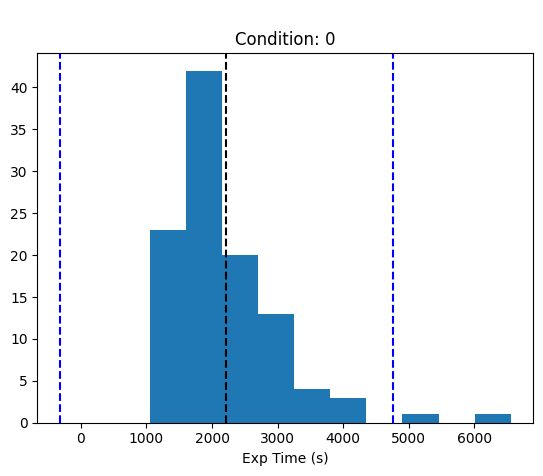

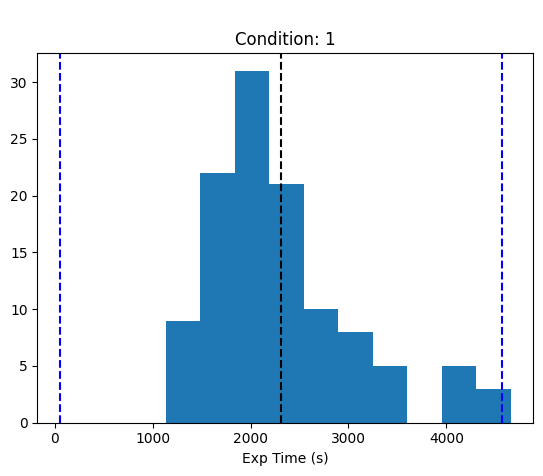

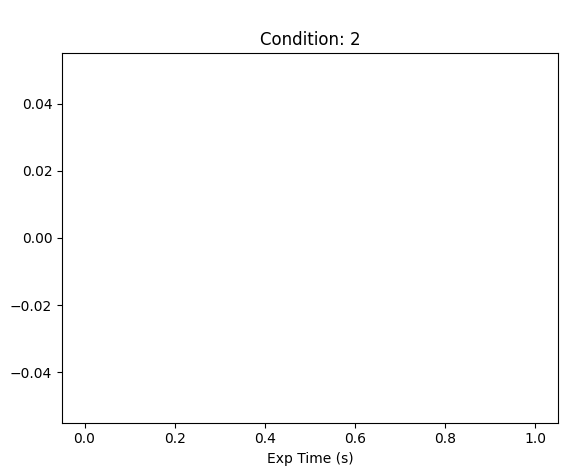

In [260]:
# Time taken per condition

exceeded_parts = []

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    condition_df = complete_data.loc[complete_data.condition == condition]
    clength = condition_df.expLength
    mean = clength.mean()
    sd = clength.std()
    med = clength.median()
    print("Mean: " + str(mean/60))
    print("Std: " + str(sd/60))
    print("Median: " + str(med/60))
    
    time_exceed_df = condition_df.loc[(condition_df.expLength > mean + 3*sd) | (condition_df.expLength < mean - 3*sd)]
    exceeded_parts += list(time_exceed_df.workerId)
    
    plt.figure()
    plt.hist(clength)
    plt.axvline(mean, linestyle='--', color='black')
    plt.axvline(mean + 3*sd, linestyle='--', color='blue')
    plt.axvline(mean - 3*sd, linestyle='--', color='blue')
    plt.title("\nCondition: " +str(condition))
    plt.xlabel("Exp Time (s)")
    
plt.show()


In [261]:
# Excluding participants based on time

within_time_parts = complete_data.loc[~complete_data.workerId.isin(exceeded_parts)]
print(len(within_time_parts.loc[within_time_parts.condition == 0]))
print(len(within_time_parts.loc[within_time_parts.condition == 1]))
print("\n")
for part in exceeded_parts:
    print(part, list(complete_data.loc[complete_data.workerId == part]["condition"])[0])

105
113


60ed6ef739959cc28d143526 0
60f7fe3289f34e538e2d436e 0
616657d3063dd77f0ad2b866 1


In [282]:
for p in exceeded_parts:
    excluded_parts.append({
        "workerId": p,
        "reason": "exceededTime"
    })

In [263]:
# Excluding participants based on effort
ineffortful_parts = within_time_parts.loc[within_time_parts.effort > 1]
ineffortful_parts[["workerId", "condition", "effort"]]


,workerId,condition,effort
83,615349801b7897c0c37bd359,0,3
129,615dd36156bf443246c0b660,0,2
266,5d55a0f63af827001981b8d6,1,3


In [264]:
effortful_parts = within_time_parts.loc[~within_time_parts.workerId.isin(list(ineffortful_parts.workerId))]
print(len(effortful_parts.loc[effortful_parts.condition == 0]))
print(len(effortful_parts.loc[effortful_parts.condition == 1]))


103
112


In [265]:
for p in ineffortful_parts.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "noeffort"
    })

In [266]:
# Excluding participants who already have done the task
for idx, (workerId, ans) in effortful_parts[["workerId","alreadyParticipated"]].iterrows():
    if "no" not in ans.lower() and "never" not in ans.lower():
        print(workerId, ans)

5dc3ebd9d0b86f2c8dc18c30 I am pretty sure I haven't played this game before.
606c6e9f7e86c0264ab3d7d8 Yes, but this one was different. The inspected values only remained for a few seconds.
6166a03f5063db088c458b73 It was my first time participating in this HIT 
6112aa865f237cf99d0b0094 this was the first one
5c28d36b6fbaed00010847a8 I haven't participated in a HIT game before. 
63174af7d57182f9bf90c094 yes, I did
605de3af48d7a575adb95b09 yes
60c142fad3c33f80288c9aa2 Nah hadn't participated in a Web of Cash HIT before. But very interested on doing similar HITs.
6152d2c25633d4867ff66ac7 yes
60a3fe2d888e7a090d6d8f82 
614e446e77a6b2d836cb3817 I CANT REMEMBER
5eb12f8510e0ce205e7b25c7 N/A
61054d9e01155b7e94f9652f this was my first time doing a web of cash HIT, or any other HIT for that matter
631610af8e747093cd90e00d I don't believe I've done this before.
61088f5351df7edad3fa8c5f it was my first 
5fa0091ec747500252d2891f This was my first time
5e8e38da572c650e2ede51c9 NA
61267b828ead584bcf09

In [267]:
# Already participated have to be filtered manually

already_participated_ids = ["606c6e9f7e86c0264ab3d7d8", "63174af7d57182f9bf90c094",
                            "605de3af48d7a575adb95b09", "6152d2c25633d4867ff66ac7", "61267b828ead584bcf092e35"]

already_participated = effortful_parts.loc[effortful_parts.workerId.isin(already_participated_ids)]
already_participated[["workerId", "condition"]]

,workerId,condition
41,606c6e9f7e86c0264ab3d7d8,0
74,63174af7d57182f9bf90c094,0
89,605de3af48d7a575adb95b09,0
115,6152d2c25633d4867ff66ac7,1
256,61267b828ead584bcf092e35,1


In [268]:
for p in already_participated.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "alreadyparticipated"
    })

In [269]:
new_parts = effortful_parts.loc[~effortful_parts.workerId.isin(already_participated_ids)]
print(len(new_parts.loc[new_parts.condition == 0]))
print(len(new_parts.loc[new_parts.condition == 1]))

100
110


In [270]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = new_parts.loc[new_parts.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

100
103


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
2,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1657.000,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.60,1199.156,-457.844,17257.050,0.0
3,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.60,1006.268,-440.615,18855.975,0.0
4,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2166.000,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.40,1736.868,-429.132,34270.925,0.0
5,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2286.000,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.00,1882.504,-403.496,18461.450,0.0
6,5b52fb6cb3c9400001f23bb5,2023-08-03 13:51:37.204959,2023-08-03 14:15:46.823171,2023-08-03 13:51:45.870025,3,firefox,windows,en-US,1449.0,1440.000,...,it was difficult as i couldn't get a pattern e...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-270.40,1058.214,-381.786,20962.625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,6173a66fe893f70a2506e6f3,2023-08-03 13:56:39.844314,2023-08-03 14:26:23.505742,2023-08-03 13:56:53.257462,3,chrome,windows,en-US,1783.0,1770.000,...,"Moderately difficult, It took a couple of roun...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1493.80,1171.804,-598.196,23412.625,0.0
270,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2081.000,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.80,1604.206,-476.794,25133.225,0.0
271,5fb70800c645491e11fdb192,2023-08-04 14:30:11.846204,2023-08-04 15:11:57.632826,2023-08-04 14:30:45.343050,3,chrome,windows,en-GB,2505.0,2472.000,...,"it wasnt difficult, i just adopted the new str...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,799.05,1940.350,-531.650,22385.200,0.0
273,6165807b8ff762a9e038b561,2023-08-04 09:42:01.492257,2023-08-04 10:11:28.453303,2023-08-04 09:42:15.674280,3,firefox,windows,en-US,1766.0,1752.000,...,not very difficult. Time and the ability to re...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1109.80,1361.610,-390.390,26854.975,0.0


In [271]:
# Excluding participants

invalid_click_strat_data = new_parts.loc[~new_parts.clickStratsValid]
for p in invalid_click_strat_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "invalidClickStrats"
    })

In [272]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = new_parts.loc[new_parts.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1181.364
Std: 920.6115852041626
Median: 1343.0

Condition: 1
Mean: 1029.5918181818183
Std: 826.4845031078308
Median: 1245.6

Condition: 2
Mean: nan
Std: nan
Median: nan


In [283]:
# Updating all files of participants whose data should be excluded

for ep in excluded_parts:
    w = ep["workerId"]
    # Get the file name 
    file = [fn for fn in os.listdir(datafolder) if w in fn][0]
    fpath = datafolder + file
    # Read the json
    with open(fpath, 'r') as f:
        participant = json.load(f)
    # Add the fields
    participant["excludeReason"] = ep["reason"]
    # Rewrite the file
    with open(fpath, 'w') as fw:
        json.dump(participant, fw)
    print(f"Wrote to {file}")
    
    

Wrote to full_3_61375098ac2bf903b0364ec3.json
Wrote to full_2_615ad127d286180356188f84.json
Wrote to full_4_6112d782efc9ce932196cc7e.json
Wrote to full_3_603ea08e7dc2aaf9eb6d9225.json
Wrote to full_3_611441187aa655b0bd7a7c69.json
Wrote to full_2_60d65e8c766ade1e2fcd362b.json
Wrote to full_3_60d1bf1c234f11f55bfcd276.json
Wrote to full_5_607c1d635d5767489a9623eb.json
Wrote to full_4_6128da24dd2b6292c122edb3.json
Wrote to full_4_60d096244aeaf354bdff6c0f.json
Wrote to full_5_60fe162c674236016c66145f.json
Wrote to full_3_6455c9898efbcab4a705968b.json
Wrote to full_3_611cbdbbd719071f5e227164.json
Wrote to full_3_612cb8236aa1cef2599e6f59.json
Wrote to full_4_60b0f62eb8e276ae78fd6180.json
Wrote to full_4_64699c39810132db3b4250b1.json
Wrote to full_2_60be90f1912d5331e734e92c.json
Wrote to full_4_611d0d396f50f8e800c6b740.json
Wrote to full_2_615b37de9f81596034aeb896.json
Wrote to full_2_610d4b020c0ec927cbd29bb4.json
Wrote to full_4_6152f8ecefde7f8298316ee6.json
Wrote to full_2_60f99eebe697a698c8

In [281]:
sorted(list(new_parts.workerId))

['558841bdfdf99b4020ba0902',
 '56f81ffe1b99b8000636b9c8',
 '5ad5b79ce704600001542ec7',
 '5b2c0994f1ca3c000190196a',
 '5b51e5f2fde5fe000162df3a',
 '5b52fb6cb3c9400001f23bb5',
 '5be9784e18a71d0001317761',
 '5c28d36b6fbaed00010847a8',
 '5cf91e3f1756e60017a30568',
 '5d77a3cabdd252000197e86e',
 '5db050bee16e28001752bc92',
 '5dc3ebd9d0b86f2c8dc18c30',
 '5de60f418f5cd559c333199c',
 '5e289268cebc01066df1db2b',
 '5e593e1b5f129b0168be047a',
 '5e8e38da572c650e2ede51c9',
 '5e9027110aacc7320bd9a84b',
 '5e930e7f1baf78649acfc7c4',
 '5e9822781c48fa016d3ea705',
 '5e98ebda7eda83135fb21c30',
 '5e9efe26ffd5fe04e506d7f3',
 '5ea62c8bba2bb363b85cbbd2',
 '5ea7caacf5d2171a87ce9dea',
 '5ea96886ef7ece0604eee527',
 '5eb12f8510e0ce205e7b25c7',
 '5ec95924a88e734583d2d2b8',
 '5ee10f63a397864aba0bcc09',
 '5ef9b70e432ef80119d3d829',
 '5f04de147fee46163c1b40e1',
 '5f0f4e2e850b230eb3e7bb95',
 '5f1c5d097881234e5034cb12',
 '5f227527667206737350c7c3',
 '5f5f5c0ab70c7b000ad0d7b7',
 '5f9ac9de923dca223848cf19',
 '5fa0091ec747

# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [88]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [89]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [90]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            if trial_count > 40: 
                print(workerId)
                continue
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1


In [81]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [91]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [42]:
len(complete_data)

10

In [43]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: Reading the instruction was a bit hard, hard to apply to.
Already participated: No
Comments: None


Feedback: It was a little tricky at first to remember all the information I had read before that on the nodes and numbers and inspection of the nodes and penalties, but I eventually figured it out.
Already participated: no, i have not participated before


Feedback: No, everything was clear.
Already participated: I have not participated in this Web of Cash study before.


Feedback: no
Already participated: no
Comments: none


Feedback: I struggle with the concept of the node inspector on the first two times but quickly figured out how it worked. I initially thought I had to follow through with the route of the nodes I checked.
Already participated: No, I have never participated in this HIT
Comments: No


Feedback: Concepts, what here is a level or what the values popping up mean, it was a lot of info for a simple task, which only turned it into a difficult one,.
Already partici

In [284]:
# Demographics:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 30.114
		SD: 10.423
		Median: 28.000
		Max: 76.000
		Min: 19.000
	Control:
		Mean: 29.320
		SD: 9.961
		Median: 27.000
		Max: 67.000
		Min: 19.000
	Misaligned:
		Mean: 30.836
		SD: 10.820
		Median: 28.000
		Max: 76.000
		Min: 20.000
Gender stats:
	Overall:
		Male: 80 (38.10%)
		Female: 129 (61.43%)
		Other: 1 (0.48%)
	Control:
		Male: 40 (40.00%)
		Female: 60 (60.00%)
		Other: 0 (0.00%)
	Misaligned:
		Male: 40 (36.36%)
		Female: 69 (62.73%)
		Other: 1 (0.91%)


In [285]:
# Effort:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}


for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    print("\n" + conditions[cond])
    print(sub_df["effort"].value_counts())




Control
effort
0    89
1    11
Name: count, dtype: int64

Misaligned
effort
0    100
1     10
Name: count, dtype: int64


In [45]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------


------ Misaligned ------

Strategy Used: Move to the end node with the highest positive number. 
How strategy was improved: Yes. from 31 - 40. I started looking at maximizing from nodes 3 to 5.
Difficulty: It was difficult as the webs were all random and the cost of revealing ate into my final score


Strategy Used:  I first started by checking if by chance I could get high figures, then I inspected nodes, then I figured it would be best to end at the top right nodes as the chances of them being - was less, and at the end I figured out which nodes to inspect and follow the path to that node.
How strategy was improved:  I first started by checking if by chance I could get high figures, then I inspected nodes, then I figured it would be best to end at the top right nodes as the chances of them being - was less, and at the end I figured out which nodes to inspect and follow the path to that node.
Difficulty: It was not that difficult I just had to figure all the t

In [49]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in list(complete_data.workerId): continue
        printed = False
        print("\n", part["workerId"], part["clickStratsValid"])
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


------ Misaligned ------


 612537b2bd6b4a38f4e7f63a True
In most rounds, I clicked the nodes at the first level.                                      	 D
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 SD
When ..., it was NOT ONLY to receive the immediate $0.25 reward.                             	 SD
When ..., I did it to see the numbers that were present at those nodes.                      	 SA
When ..., I did for another reason than to see the numbers that were present at those nodes. 	 SD
When ..., I paid attention to the numbers that were present at those nodes.                  	 SD
When ..., I did NOT pay attention to the numbers that were present at those nodes.           	 SD



 60f71652cf1833110dd7c9cf True
In most rounds, I clicked the nodes at the first level.                                      	 NDNA
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 D
W

0.11644350627390096


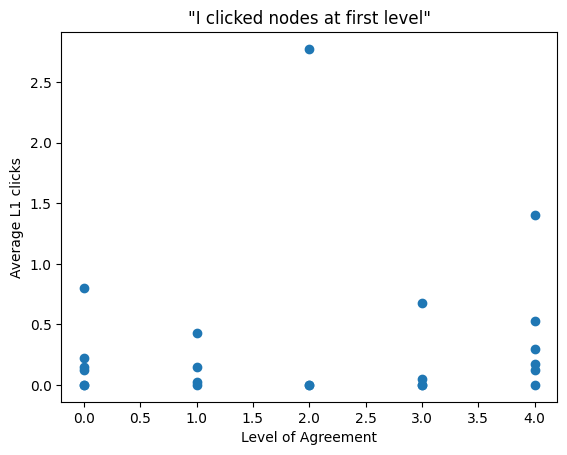

In [259]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



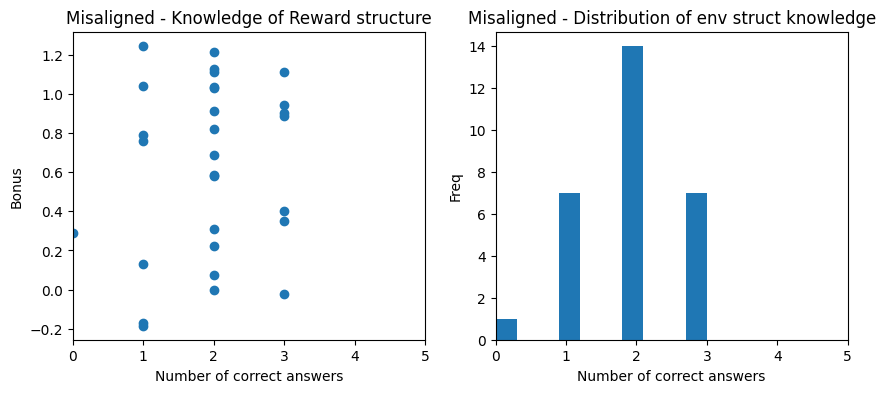

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}